In [10]:
''' IMPORT ALL THE THINGS '''
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array, smart_resize
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.applications.vgg16 import VGG16

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
''' DEFINE VARIABLES '''

CWD = os.getcwd().replace('\\','/') # get current workspace directory
IMAGE_DIR = f'{CWD}/drive/MyDrive/dataset/orange-classification'
TRAIN_DATASET_DIR = f'{IMAGE_DIR}/train'
TEST_DATASET_DIR = f'{IMAGE_DIR}/test'
VAL_DATASET_DIR = f'{IMAGE_DIR}/validation'

CATEGORIES = ['clementine','grapefruit','orange']

IMAGE_RESIZE = (224, 224) # size of image to put in Model

AUGMENT_N_IMAGE = 4 # how many time each image get the augmentation

AUGMENT_SAVE_PREFIX = 'aug'

Save_model = 'Model1'


In [27]:
''' Create Data Augmentation '''
def run_augmentation( isRun = 0 ):

    if isRun:

        print('Running Augmentation...\n')

        datagen = ImageDataGenerator(
            rotation_range=45,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='reflect' # optional : nearest, constant(125), reflect, wrap
        ) 

        try:
            for category in CATEGORIES:

                train_image_in_directory = [] 

                train_category_directory = f"{TRAIN_DATASET_DIR}/{category}"

                for i, image_name in enumerate(os.listdir(train_category_directory)):
                    
                    file_path = f"{train_category_directory}/{image_name}"
                    
                    if (image_name.find(AUGMENT_SAVE_PREFIX) != -1):  # delete old augmentation
                        if (os.path.exists(file_path)):
                            os.remove(file_path)

                    elif (image_name.split('.')[1] in ['png', 'jpg', 'jpeg']):

                        image = load_img(file_path)
                        image = smart_resize(image, IMAGE_RESIZE)
                        image = img_to_array(image)
                        train_image_in_directory.append(image)

                train_image_in_directory = np.array(train_image_in_directory)
                print(f"{category} : ", end="")
                print(train_image_in_directory.shape)

                i = 0
                
                # save_to_dir (option) : f'{train_category_directory}', 'augmented'
                for batch in datagen.flow(train_image_in_directory, batch_size=1, save_to_dir=f'{train_category_directory}', save_prefix=AUGMENT_SAVE_PREFIX, save_format='jpg'):
                    i += 1
                    # datagen.flow make infinite loop NEED A MANUAL BREAK!!!
                    if i >= len(train_image_in_directory) * AUGMENT_N_IMAGE:
                        break

            print('\nAugmentation Success!!!')

        except Exception as e:

            print('\nAugmentation Failed...')
            print('Exception is\n',e)
    
    


In [14]:
run_augmentation(0)

In [28]:
''' LOAD DATA into Variables '''
try:
    print("Loading data...\n")
    
    print('-----------Train-----------')
    #Load train data

    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        TRAIN_DATASET_DIR, # train_data path
        image_size=IMAGE_RESIZE, # each image resize
        batch_size=1,
        label_mode='categorical',
        color_mode='rgb',
        shuffle=True
    )

    print(train_dataset.class_names)  # class check
    print(train_dataset)


    print("-----------Validation-----------")
    #Load validation data
    valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        VAL_DATASET_DIR,  # validation_data path
        image_size=IMAGE_RESIZE,  # each image resize
        batch_size=1, 
        label_mode='categorical',
        color_mode='rgb',
        shuffle=True
    )

    print(valid_dataset.class_names)  # class check
    print(valid_dataset)

    print("\nLoad data Success!!!")
    
except Exception as e:

    print("\nLoad data failed...")
    print("Exception is",e)




Loading data...

-----------Train-----------
Found 1990 files belonging to 3 classes.
['clementine', 'grapefruit', 'orange']
<BatchDataset shapes: ((None, 224, 224, 3), (None, 3)), types: (tf.float32, tf.float32)>
-----------Validation-----------
Found 567 files belonging to 3 classes.
['clementine', 'grapefruit', 'orange']
<BatchDataset shapes: ((None, 224, 224, 3), (None, 3)), types: (tf.float32, tf.float32)>

Load data Success!!!


In [29]:
''' Get pre train model '''
VGG = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
VGG.trainable = False

Epoch 1/10
1990/1990 [==============================] - 22s 11ms/step - loss: 24.2401 - accuracy: 0.4417 - val_loss: 8.0009 - val_accuracy: 0.3633
Epoch 2/10
1990/1990 [==============================] - 20s 10ms/step - loss: 4.5409 - accuracy: 0.4588 - val_loss: 1.3171 - val_accuracy: 0.4180
Epoch 3/10
1990/1990 [==============================] - 20s 10ms/step - loss: 3.7882 - accuracy: 0.4246 - val_loss: 2.0424 - val_accuracy: 0.4092
Epoch 4/10
1990/1990 [==============================] - 20s 10ms/step - loss: 3.1655 - accuracy: 0.4055 - val_loss: 1.4785 - val_accuracy: 0.3651
Epoch 5/10
1990/1990 [==============================] - 20s 10ms/step - loss: 2.5449 - accuracy: 0.3905 - val_loss: 1.6571 - val_accuracy: 0.3721
Epoch 6/10
1990/1990 [==============================] - 20s 10ms/step - loss: 2.3487 - accuracy: 0.3754 - val_loss: 1.1238 - val_accuracy: 0.3668
Epoch 7/10
1990/1990 [==============================] - 20s 10ms/step - loss: 1.7291 - accuracy: 0.3789 - val_loss: 1.3640 

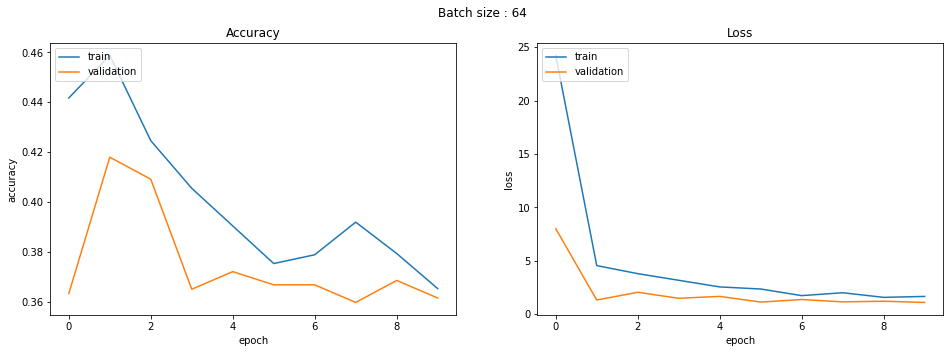

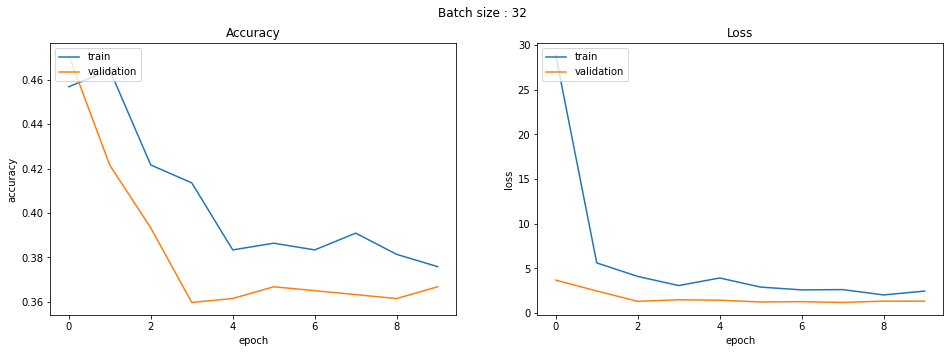

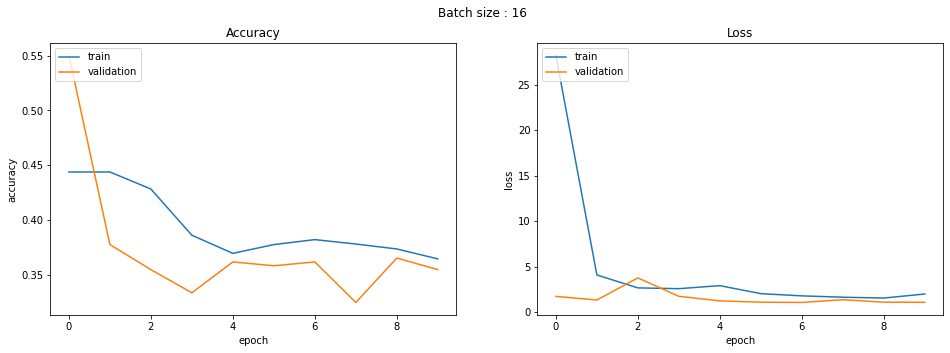

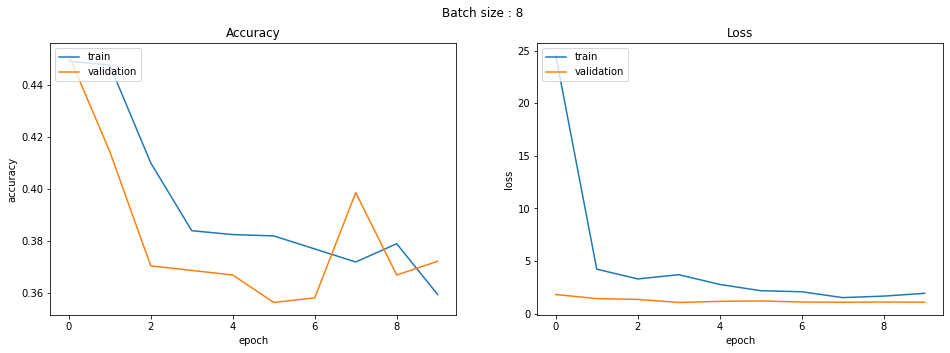

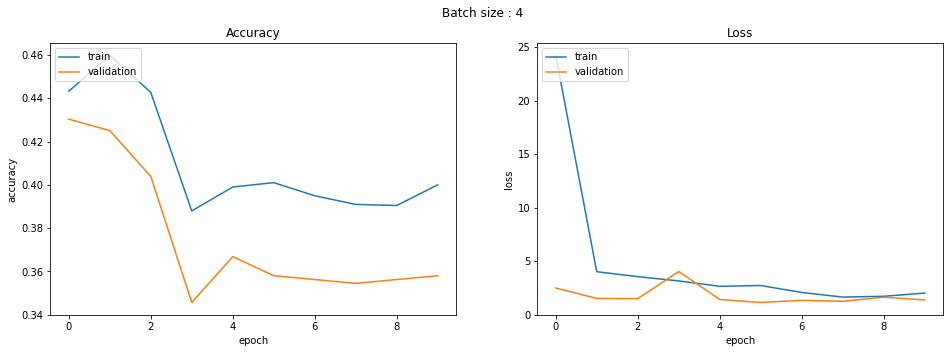

In [31]:
''' Training and Display result'''
#BATCH_SIZE = [512, 256, 128, 64, 32, 16, 8, 4]
BATCH_SIZE = [ 64, 32, 16, 8, 4]
for i, batch in enumerate(BATCH_SIZE):
    
    # create model architecture
    model = tf.keras.models.Sequential([
                                    VGG,
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(512, activation='relu'),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(512, activation='relu'),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(3, activation='softmax')
    ])
    
    # compile
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    los = tf.keras.losses.categorical_crossentropy
    model.compile( optimizer = opt , loss = los , metrics = ['accuracy'] )
    
    # Training
    model.fit(
        
        train_dataset,  # both data and label cause we use preprocessing
        validation_data=valid_dataset,
        batch_size=batch,
        epochs=10, ### can be change
        shuffle=True 
    )
    
    # Plot the result
    fig, axs = plt.subplots(1,2, figsize=(16,5))
    fig.suptitle(f"Batch size : {batch}")
    axs[0].plot(model.history.history['accuracy'])
    axs[0].plot(model.history.history['val_accuracy'])
    axs[0].set_title('Accuracy')
    axs[0].legend(['train', 'validation'], loc='upper left')
    axs[0].set(xlabel='epoch', ylabel='accuracy')

    axs[1].plot(model.history.history['loss'])
    axs[1].plot(model.history.history['val_loss'])
    axs[1].set_title('Loss')
    axs[1].legend(['train', 'validation'], loc='upper left')
    axs[1].set(xlabel='epoch', ylabel='loss')
    
    ''' Save the model '''
    model.save(f'{CWD}/Model/{Save_model}/{batch}')